In [ ]:
!ls  /datasets/dzanga-bai/dzanga-bai/spectrograms/ | wc -l

862


In [ ]:
from fastai.vision.all import *

In [ ]:
path = Path("/datasets/dzanga-bai/dzanga-bai/")
Path.BASE_PATH = path

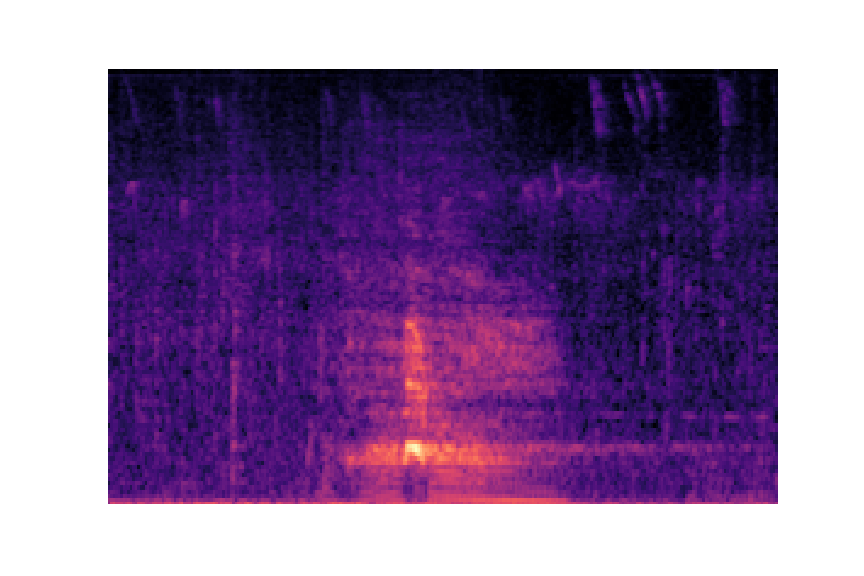

In [ ]:
# Print a spectrogram
p = (path/"spectrograms").ls()[2]
img = PILImage.create(p); img

In [ ]:
# Get an idea of the shape, 3 color channels, 576*864 pixels
tconv = ToTensor()
img = tconv(img)
img.shape,type(img)

(torch.Size([3, 576, 864]), fastai.torch_core.TensorImage)

In [ ]:
df = pd.read_excel((path/"Age-sex calls- Dzanga Bai.xlsx"), sheet_name="context")
df.head()

,unique_ID,call_type,comb,in_analysis,final_cat,final_subcat,distress,age,sex,agsex
0,opp_330_ru,ru,n,y,nrs,nrs,na,juv,un,un
1,opp_332_ru,ru,n,y,logistics,leave,na,ad,f,adf
2,opp_333_ru,ru,n,y,unspecific,unspecific,na,ad,f,adf
3,opp_333_ru1,ru,n,y,unspecific,unspecific,na,ad,f,adf
4,opp_333_ru2,ru,n,y,unspecific,unspecific,na,ad,f,adf


In [ ]:
#create spectrogram paths in dataframe
df["path"] = df['unique_ID'].apply(lambda x: f"{str(path)}/spectrograms/{x}.png")

In [ ]:
#make sure paths exist
df["exists"] = df["path"].apply(lambda x: Path(x).is_file())

In [ ]:
#Check all files in file exist as spectrograms
assert np.sum(df.exists) == len(df)

## Create Test set and cross-validation folds based on demographic characteristic

The rationale here is that we can have separate test sets that follow the distribution of the population depending on demographic characteristic of interest. 
This allows us to use more of the data. The balanced folds also allows cross-validation to be more representantive of the data distribution.


### Analysis for Age class prediction

We will follow a 80/20 Train/Test set. 
We also noticed missclasification between groups close in age so we will change this multiclass problem into a binary classification problem by grouping aduts/small adults and infants/juveniles

In [ ]:
set(df.age.values)

{'ad', 'inf', 'juv', 'sa', 'un'}

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit


# keep only valid ages
dfx = df[df['age']!="un"]

# create age categorizations
dfx["agecat"] = df["age"].apply(lambda x: "ad/sa" if x in ("ad","sa") else "inf/juv")

# create stratified train/test splits
y = dfx.agecat.values
print(len(y),len(dfx), len(df))
sss = StratifiedShuffleSplit(n_splits=1,test_size=0.2, random_state=42)

for train_idx, test_idx in sss.split(np.zeros(len(y)), y):
    print("TRAIN:", test_idx, "TEST:", test_idx)

# Bool to flag if image is part of the test set
dfx["is_test"] =  dfx.index.isin(test_idx)


354 354 389
TRAIN: [ 93 312   9 185 206 294 305 248 172  17 104 341  23 304 340  99  90 267
 270  89   2 268  80 149 214  33 156 328 165 100  82  65 291 284 253 200
 345 242  27 180   0  86 323 220 135  78 353 169 283 339 233 134 281 118
 306  51  38  30 266 139 346 150 155 112  83 297 301 146 113 230 310] TEST: [ 93 312   9 185 206 294 305 248 172  17 104 341  23 304 340  99  90 267
 270  89   2 268  80 149 214  33 156 328 165 100  82  65 291 284 253 200
 345 242  27 180   0  86 323 220 135  78 353 169 283 339 233 134 281 118
 306  51  38  30 266 139 346 150 155 112  83 297 301 146 113 230 310]
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/shared-libs/python3.7

In [ ]:
# Keeping code in case needed
#from sklearn.model_selection import StratifiedShuffleSplit


#keep only valid ages
#dfx = df[df['age']!="un"]
#y = dfx.age.values
#print(len(y),len(dfx), len(df))
#sss = StratifiedShuffleSplit(n_splits=1,test_size=0.2, random_state=42)

#for train_idx, test_idx in sss.split(np.zeros(len(y)), y):
#    train_df=dfx[dfx.index.isin(train_idx)]
#    test_df=dfx[dfx.index.isin(test_idx)]

 
#print(f"Training set: {len(train_df)}, Hold out test set: {len(test_df)}")

354 354 389
Training set: 257, Hold out test set: 64


In [ ]:
df_temp = dfx[["path","agecat","age","is_test"]]
df_temp.head()
 

,path,agecat,age,is_test
0,/datasets/dzanga-bai/dzanga-bai/spectrograms/opp_330_ru.png,inf/juv,juv,True
1,/datasets/dzanga-bai/dzanga-bai/spectrograms/opp_332_ru.png,ad/sa,ad,False
2,/datasets/dzanga-bai/dzanga-bai/spectrograms/opp_333_ru.png,ad/sa,ad,True
3,/datasets/dzanga-bai/dzanga-bai/spectrograms/opp_333_ru1.png,ad/sa,ad,False
4,/datasets/dzanga-bai/dzanga-bai/spectrograms/opp_333_ru2.png,ad/sa,ad,False


## Fitting the model

Model fitting was done externally, here we create the dataloader and view the images

In [ ]:
from fastai.callback.fp16 import *

# Resizing by squishing to preserve image to 512, small batch size needed to fit into memory
dls = ImageDataLoaders.from_df(df_temp, path="/",  valid_col='is_test',bs=12,item_tfms=Resize(512, method="squish"))

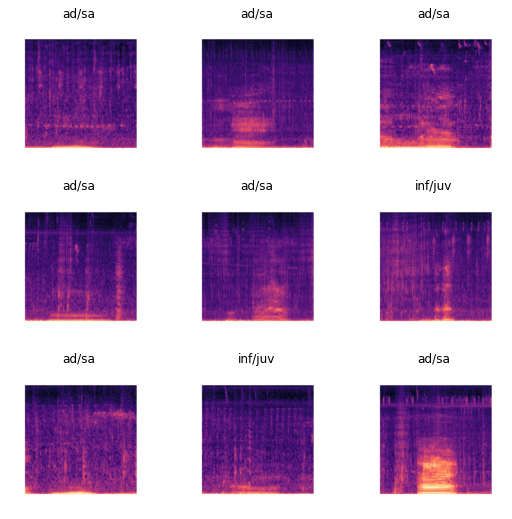

In [ ]:
dls.show_batch()

In [ ]:
#!pip install ipywidgets
#!jupyter nbextension install --py widgetsnbextension
#!jupyter nbextension enable widgetsnbextension --py

In [ ]:
# Specifying the model for diagnostic use
learn = cnn_learner(dls, resnet152,                
                metrics=[accuracy, error_rate]).to_fp16()

#_ =learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

/shared-libs/python3.7/py/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/shared-libs/python3.7/py/lib/python3.7/site-packages/torch/cuda/amp/autocast_mode.py:120: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


Running out of RAM, will move analysis to local server and deploy trained model here. Not likely to have much success training without a GPU

## Model performance and diagnostics

Loading the externally trained model

In [ ]:
# Override load method
@patch
@delegates(load_model)
def load(self:Learner, file, device=None, **kwargs):
    "Load model and optimizer state (if `with_opt`) from `self.path/self.model_dir/file` using `device`"
    if device is None and hasattr(self.dls, 'device'): device = self.dls.device
    if self.opt is None: self.create_opt()
    #file = join_path_file(file, self.path/self.model_dir, ext='.pth')
    load_model(file, self.model, self.opt, device=device, **kwargs)
    return self

/shared-libs/python3.7/py/lib/python3.7/site-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


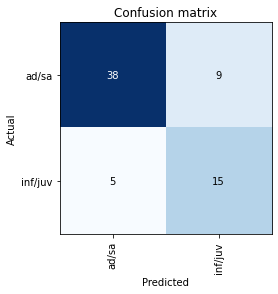

In [ ]:
path = Path("/datasets/dzanga-bai/dzanga-bai")
learn.load(path/"models/baseline_resnet152.pth")
 
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.print_classification_report()

              precision    recall  f1-score   support

       ad/sa       0.88      0.81      0.84        47
     inf/juv       0.62      0.75      0.68        20

    accuracy                           0.79        67
   macro avg       0.75      0.78      0.76        67
weighted avg       0.81      0.79      0.80        67



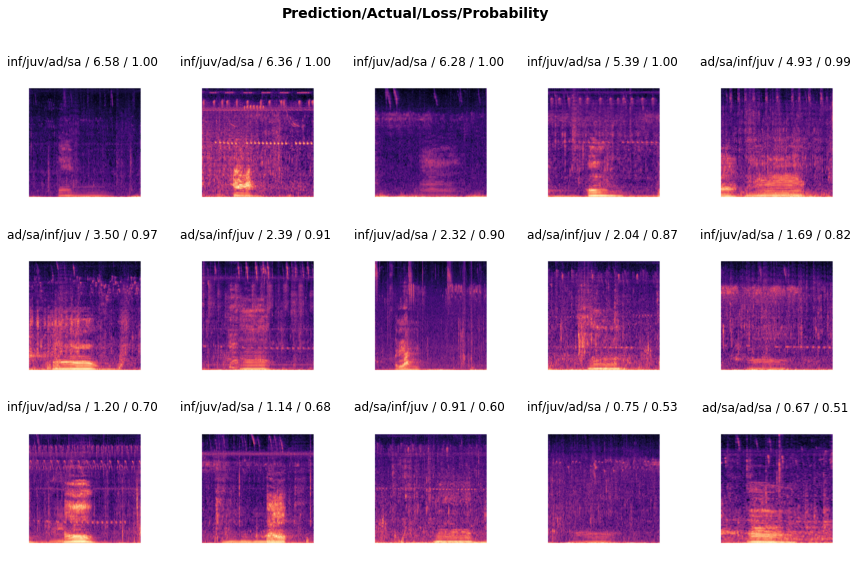

In [ ]:
# Misclassifications ordered by models certainty 
interp.plot_top_losses(15)

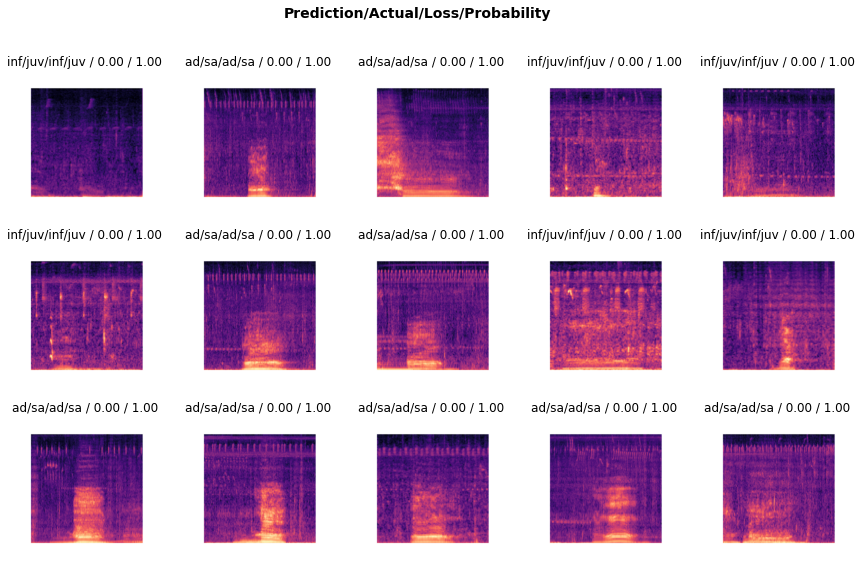

In [ ]:
# Top 15 best classifications
interp.plot_top_losses(15, largest=False)

In [ ]:
# attempt inference by grabbing one image from the test set
f = dfx.path[dfx.is_test][0]

img = PILImage.create(f)
learn.predict(img)

/shared-libs/python3.7/py/lib/python3.7/site-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


('inf/juv', tensor(1), tensor([0.4637, 0.5363]))

In [ ]:
# Actual label
dfx.agecat[dfx.path==f]

0    inf/juv
Name: agecat, dtype: object

### Sex Classification

Above steps were repeated for Gender classification with slightly less success, in the 65-75% accuracy range. These models are not heavily tuned yet, so we may still be able to build on this.
 

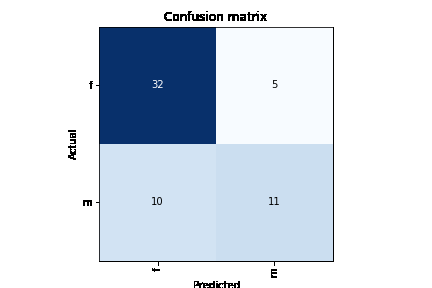

In [ ]:
img = PILImage.create(path/"images/confusion_sex_resnet50.png")
img

In [ ]:
print(f"Test set accuracy is {(32+11)/(32+11+15)}")

Test set accuracy is 0.7413793103448276


### TODO: Next steps
- We have very few examples of infants, and most of the images we have are unlabelled, need to see if researchers can label more of the existing images. Only 354 out of 862 images are available for this analysis
- Mel spectrogram may need tweaking with different parameters SR, can check with Peter and go back to previous project15 values used
- Data augmentation has not been attempted, need to see how we can change the audio files to make sounds appear closer or further away, this will allow us to greatly scale up our training data
- Next model can be fitted using pytorch and making use of the audio layer to avoid creating mel spectrograms externally, this should prevent data loss
- Provide a CAM analysis so researchers can see why our models behave the way they do, eg: why does the model think this is a male etc..
- Share our initial finding and deployed model with the researchers in the form of a webapp that they can provide their initial feedback on.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7aa10abb-09ba-4e5c-b109-d1b9cd39afe4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>